<a href="https://colab.research.google.com/github/malakanton/yandex_practicum_projects/blob/main/yandex_bank_churn_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отток клиентов

<font size=4>Постановка задачи</font>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

<font size=4>Цель проекта:</font>

Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

Построить модель предсказания максимизируя метрику F-1 и метрику ROC AUC.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
                    f1_score, plot_roc_curve, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, PredefinedSplit
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(rc={'figure.figsize':(12,6)}, style="darkgrid")

## Подготовка данных

### Загрузка данных и общая информация

In [4]:
try:
  df_raw = pd.read_csv('/datasets/Churn.csv')
except:
  df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [5]:
df_raw.shape

(10000, 14)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<font size=5> **Описание данных**</font>

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

### Обработка признаков

In [7]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Наша задача - посмтроить модель предсказания, поэтому данные в RowNumber, CustomerId, Surname для нашей задачи не нужны. Использовать их как признаки нельзя, просто удалим их. 
Приведем названия колонок к должному виду:

In [8]:
df_raw.columns = df_raw.columns.str.lower()
df = df_raw.drop(['rownumber', 'customerid', 'surname'], axis=1)
df = df.rename({'creditscore': 'credit_score',
                'numofproducts': 'num_of_products',
                'hascrcard': 'has_cr_card',
                'isactivemember': 'is_active',
                'estimatedsalary': 'estimated_salary'}, axis=1)

In [9]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Распределение признаков

Посмотрим на распределение численных признаков

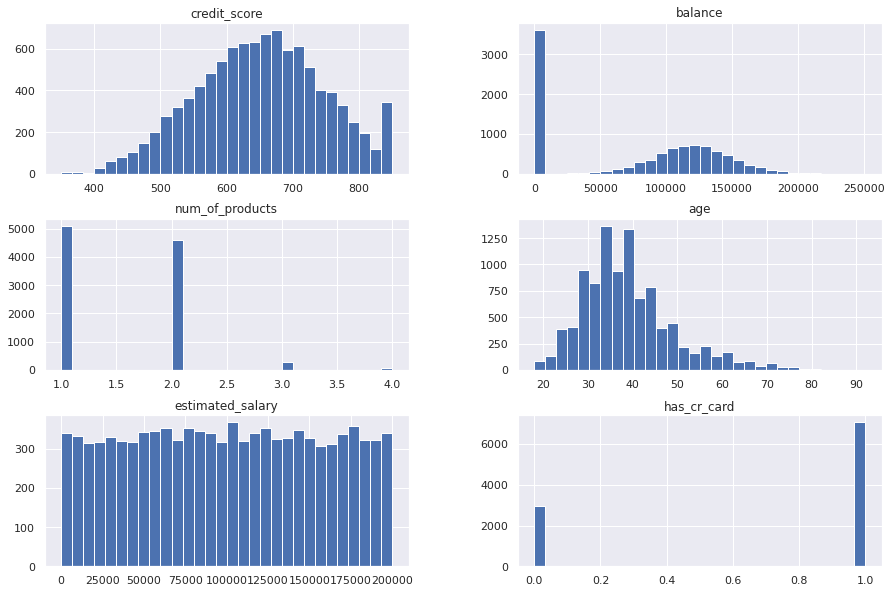

In [10]:
df[['credit_score','balance','num_of_products','age','estimated_salary','has_cr_card']]\
            .hist(figsize=(15,10), bins=30);

Из гистограмм видно:
 - Кредитный рейтинг и возраст распределены нормально
 - Баланс на счете имеет очень много нулевых значений, остальные распределены нормально
 - Предполагаемая зарплата распределена равномерно
 - Число продуктов и наличие кредитной карты - категориальные признаки

Посмотрим какие значения принимают строковые признаки:

In [11]:
df.gender.unique()

array(['Female', 'Male'], dtype=object)

In [12]:
df.gender.value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

Мужчины и женщины представлены почти в равных долях.

In [13]:
df.geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [14]:
df.geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

Больше всего клиентов из Франции, Германия и Испания представлены почти поровну. 

### Обработка пропусков

In [15]:
df.isna().mean()

credit_score        0.0000
geography           0.0000
gender              0.0000
age                 0.0000
tenure              0.0909
balance             0.0000
num_of_products     0.0000
has_cr_card         0.0000
is_active           0.0000
estimated_salary    0.0000
exited              0.0000
dtype: float64

Около 9% пропусков в признаке tenure. Многовато для того чтобы просто удалить эти строки. Посмотрим на его распределение

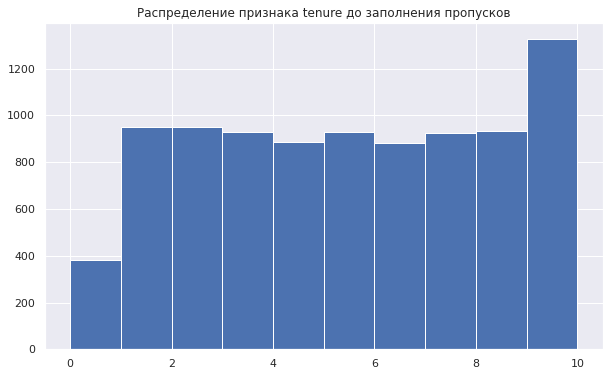

In [16]:
df.tenure.hist(bins=10, figsize=(10,6), label ='ef')
plt.title('Распределение признака tenure до заполнения пропусков');

Мы видим что этот признак распределелен почти равномерно.

Заменим пропуски в нем методом KNN:

In [17]:
df[df.tenure.isna()].head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


In [18]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')

In [19]:
df_scaled = df.copy()
dummies = pd.get_dummies(df_scaled[['geography', 'gender']], drop_first=True)
df_scaled = df_scaled.drop(['geography','gender'], axis=1)
df_scaled = pd.concat([df_scaled, dummies], axis=1)

min_max_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_scaled), columns = df_scaled.columns)
df_scaled.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,0.0,0.0,0.0
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,0.0,1.0,0.0
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,0.0,0.0,0.0
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0.0,0.0,0.0,0.0
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,0.0,1.0,0.0


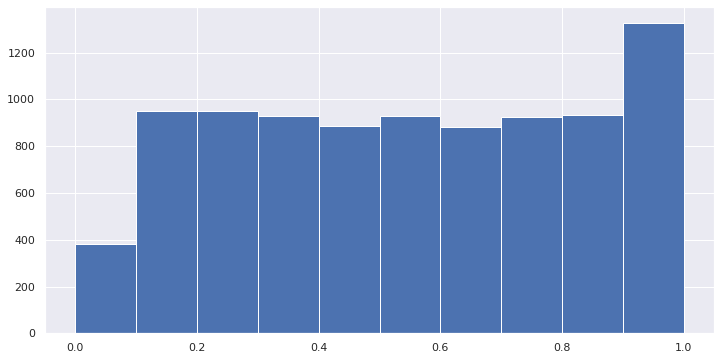

In [20]:
df_scaled.tenure.hist()

In [21]:
df_scaled = pd.DataFrame(knn_imputer.fit_transform(df_scaled),columns = df_scaled.columns)

In [22]:
df['tenure'] = df_scaled.tenure

In [23]:
df.tenure.isna().sum()

0

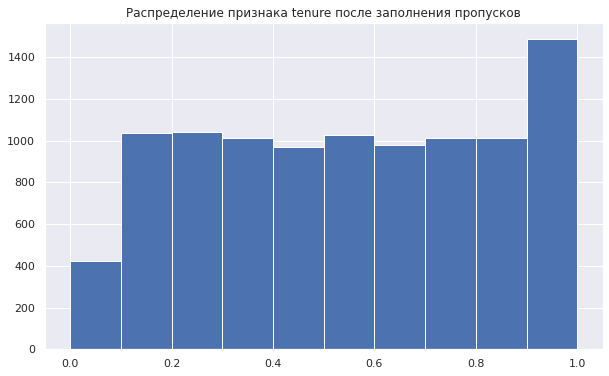

In [24]:
df.tenure.hist(bins=10, figsize=(10,6))
plt.title('Распределение признака tenure после заполнения пропусков');

 Распределение не поменялось при параметре n_neighbors=1 (при других значениях этого параметра распределение заметно искажается). Получилось более осмысленное заполнение пропусков чем просто рандомные значения конечно. Это не должно повлиять на качество модели, при этом мы сохранили 9% данных что наоборот приведет к более высокому качеству из-за бОльшего количества данных. 

## Исследование данных

Посмотрим как распределена целевая переменная:

In [25]:
df.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Налицо явный дисбаланс 80% на 20%

In [26]:
df.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.002247,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013858,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.002247,-0.013858,1.000000,-0.012785,0.012994,0.029180,-0.029752,0.007930,-0.015294
balance,0.006268,0.028308,-0.012785,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.012994,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.029180,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active,0.025651,0.085472,-0.029752,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.007930,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.015294,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Какой-либо значимой линейной зависимости нет ни по одному из признаков.

<b> Возраст</b>

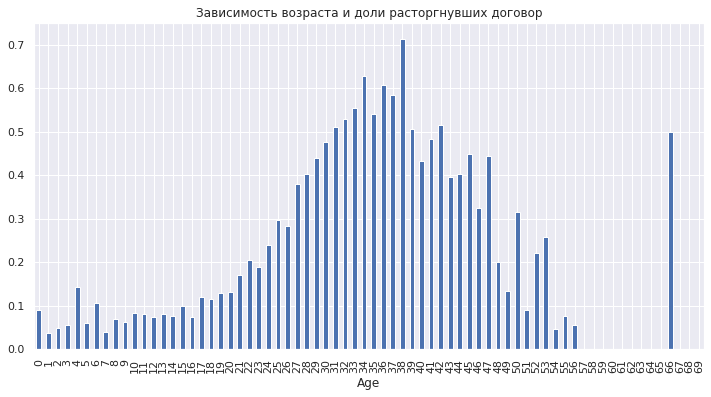

In [27]:
df.groupby('age')['exited'].mean().reset_index(drop=True).plot(kind='bar')
plt.xlabel('Age')
plt.title('Зависимость возраста и доли расторгнувших договор');

<div class="alert alert-success">
<b>Комментарий ревьюера V3✔️:</b>Кстати, как вариант тут можно на 45 повернуть возраст (чтобы читабельней стала ось OX)
</div>

До 20 лет мы видим незначительное число клиентов покидающих банк. Скорее всего это родители которые открывают счета на имя своих детей и менять банки им особенно нет смысла. 

Далее мы видим рост доли покидающих банк к 38 годам, затем спад. Люди часто меняют банк в среднем возрасте.

После 56 лет клиенты не расторгают договор вообще, однако, есть выброс на значении в 66 лет. Похоже на аномалию в данных и по-хорошему нам надо бы обратиться к источнику данных чтобы узнать причину такой аномалии.

<b> Пол</b>

In [28]:
df.groupby('gender')['exited'].mean().reset_index().rename({'exited':'exited_share'},axis=1)

,gender,exited_share
0,Female,0.250715
1,Male,0.164559


Здесь мы видим что доля женщим меняющих банк значительно выше доли мужчин. Тоже важный признак для обучения модели. 

**Страна**

In [29]:
df.groupby('geography')['exited'].mean().reset_index().rename({'exited':'exited_share'},axis=1)

,geography,exited_share
0,France,0.161548
1,Germany,0.324432
2,Spain,0.166734


Клиенты из Германии в два раза чаще расторгают договор с банком чем клиенты из Франции и Испании. 

**Продолжительность пользования услугами банка**

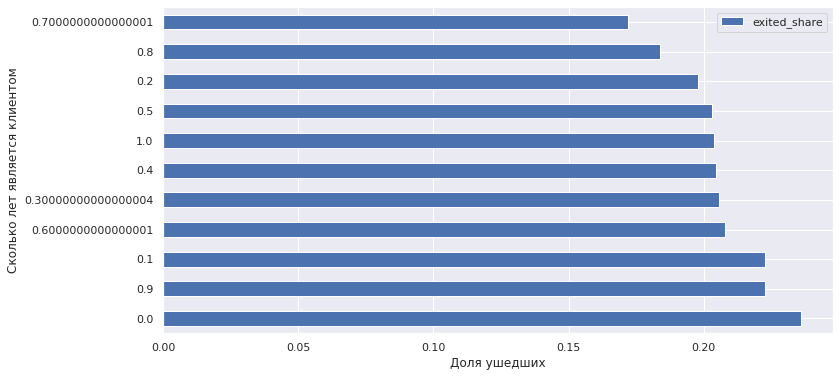

In [30]:
df.groupby('tenure')['exited'].mean()\
    .reset_index().rename({'exited':'exited_share'},axis=1)\
    .sort_values(by='exited_share', ascending=False).plot(y='exited_share', x='tenure', kind='barh');
plt.xlabel('Доля ушедших')
plt.ylabel('Сколько лет является клиентом');

Видно, что клиенты чаще уходят на первом и втором годах пользования услугами банка. Хотя разница не столь значительная чтобы говорить о сильном влиянии на целевую переменную. 

**Активность клиента**

In [31]:
df.groupby('is_active')['exited'].mean().reset_index().rename({'exited':'exited_share'},axis=1)

,is_active,exited_share
0,0,0.268509
1,1,0.142691


Довольно очевидная закономерность - если клиент не активен, он чаще расторгает договор. Однако, здесь самым важным аспектом является период неактивности по которому выставляется этот критерий. Но данных об этом у нас к сожалению нет. 

## Подготовка признаков и выборок

### Подготовка категориальных признаков

Методом One Hot Encoding преобразуем признак gender:

In [32]:
df['gender'] = pd.get_dummies(df['gender'], drop_first=True)

In [33]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited
0,619,France,0,42,0.2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,0.1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,0.8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,0.1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,0.2,125510.82,1,1,1,79084.10,0


In [34]:
df.gender.value_counts(normalize=True)

1    0.5457
0    0.4543
Name: gender, dtype: float64

Методом так же преобразуем geography:

In [35]:
geography = pd.get_dummies(df['geography'], drop_first=True)
df = df.drop('geography', axis=1)
df = pd.concat([df, geography], axis=1)
df.columns = df.columns.str.lower()
df.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active,estimated_salary,exited,germany,spain
0,619,0,42,0.2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,0.1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,0.8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,0.1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,0.2,125510.82,1,1,1,79084.10,0,0,1


### Подготовка непрерывных признаков

Для масштабирования непрерывных признаков применим StandardScaler

In [36]:
num_features = ['credit_score','age', 'balance', 'estimated_salary']

### Разбиение на выборки

Так как в дальнейшем мы будем использовать кросс-валидацию, нам потребуется только обучающая и тестовая выборки. 

In [37]:
X = df.drop('exited', axis=1)
y = df.exited

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

Проверим баланс классов в обучающей и тестовой выборках:

In [39]:
y_train.value_counts(normalize=True)

0    0.79625
1    0.20375
Name: exited, dtype: float64

In [40]:
y_test.value_counts(normalize=True)

0    0.7965
1    0.2035
Name: exited, dtype: float64

Выборки разбиты в соответствии с балансом классов изначальных данных, можно приступать к обучению.

Масштабирование признаков:

In [41]:
scaler = StandardScaler() 
scaler.fit(X_train[num_features]) 
X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Обучение без учета дисбаланса

### Логистическая регрессия

In [42]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Обучим модель с подбором гиперпараметров и кросс-валидацией на обучающей выборке:

In [43]:
grid_params = {'max_iter': range(100, 1000, 100),
              'solver': ['lbfgs', 'liblinear']}
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

lr = LogisticRegression(random_state=25, n_jobs=-1)
grid_search_cv_lr = GridSearchCV(lr, grid_params, cv=kfold, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_lr.fit(X_train, y_train)

best_lr = grid_search_cv_lr.best_estimator_
ix = grid_search_cv_lr.best_index_

print('Logistic Regression best params:', grid_search_cv_lr.best_params_)
print()
print('Logistic Regression best f1:', grid_search_cv_lr.best_score_)
print('Logistic Regression best AUC:', grid_search_cv_lr.cv_results_['mean_test_AUC'][ix])

Logistic Regression best params: {'max_iter': 100, 'solver': 'lbfgs'}

Logistic Regression best f1: 0.3110685484451358
Logistic Regression best AUC: 0.7626014673325617


Логистическая регрессия без учета дисбаланса показала очень слабый результат: метрика F1 крайне низкая, а ROC AUC не сильно выше 0.5. Очевидно, что такая модель не подходит для использования.

### Случайный лес

Обучим модель с подбором гиперпараметров и кросс-валидацией на обучающей выборке:

In [44]:
grid_params = {'min_samples_split': [2,4],
               'min_samples_leaf': [1,2],
              'n_estimators':[50,75,100,200,400],
              'max_depth':[4,6,8,12],
               }
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_cv_rf = GridSearchCV(rf, grid_params, cv=kfold, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_rf.fit(X_train, y_train)

best_rf = grid_search_cv_rf.best_estimator_
ix = grid_search_cv_rf.best_index_

print('Random Forest best params:', grid_search_cv_rf.best_params_)
print()
print('Random Forest best f1:', grid_search_cv_rf.best_score_)
print('Random Forest best AUC:', grid_search_cv_rf.cv_results_['mean_test_AUC'][ix])



Random Forest best params: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}

Random Forest best f1: 0.5709814088838335
Random Forest best AUC: 0.8518034522676629


Случайный лес немного лучше лог регрессии, хотя все равно F1 очень низкий.

Посмотрим на важность признаков по которым модель принимает решения:

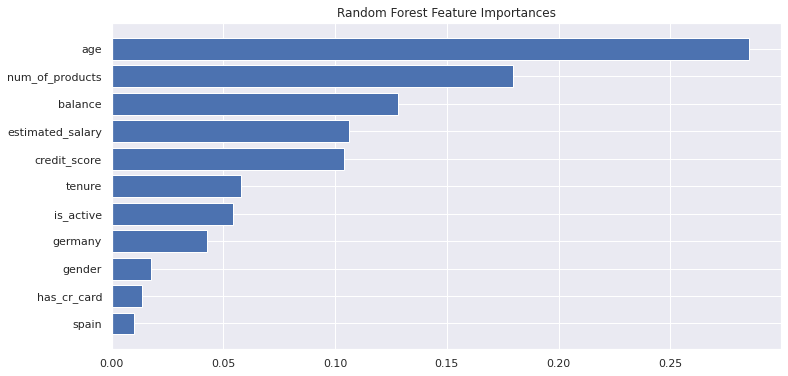

In [45]:
sort = best_rf.feature_importances_.argsort()
plt.barh(X_train.columns[sort], best_rf.feature_importances_[sort])
plt.title('Random Forest Feature Importances');

### XGBoost

In [46]:
grid_params = {'max_depth': [2,4,8,12],
             'n_estimators': [75,85,95],
             'colsample_bylevel':[0.8],
             'colsample_bynode':[0.8],
             'colsample_bytree':[0.95],
             'learning_rate':[0.01, 0.1]
             }
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

clf = XGBClassifier(random_state=42, verbosity=0)
grid_search_xgb = GridSearchCV(estimator=clf, param_grid=grid_params, cv=kfold, n_jobs=-1, scoring=scoring, refit='F1-score')

grid_search_xgb.fit(X_train, y_train)

best_xgb= grid_search_xgb.best_estimator_
ix = grid_search_xgb.best_index_

print('XGBoost best params:', grid_search_xgb.best_params_)
print()
print('XGBoost best f1:', grid_search_xgb.best_score_)
print('XGBoost best AUC:', grid_search_xgb.cv_results_['mean_test_AUC'][ix])

XGBoost best params: {'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 95}

XGBoost best f1: 0.5823574552551425
XGBoost best AUC: 0.8510815473519769


XGBoost приблизился к целевому показателю метрики F1, но все равно еще требует корректировки.

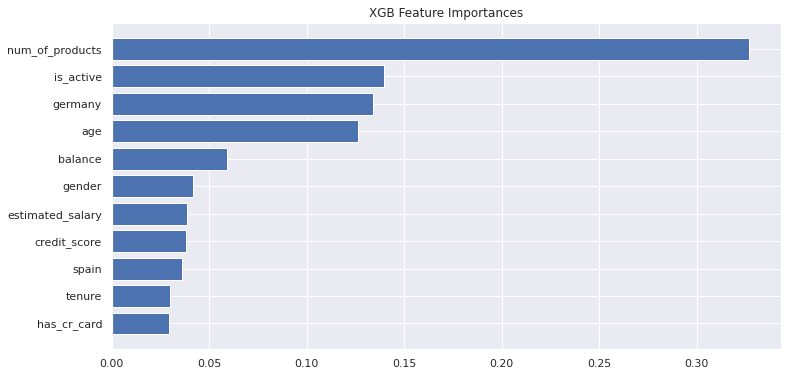

In [47]:
sort = best_xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sort], best_xgb.feature_importances_[sort])
plt.title('XGB Feature Importances');

## Борьба с дисбалансом

### Изменение порога принятия решения

Посмотрим как можно изменить порог принятия решения для случайного леса.

А вот здесь нам все-таки понадобится валидационная выборка:

In [48]:
X_valid, X_test_thr, y_valid, y_test_thr = train_test_split(X_test, y_test, test_size=.5, 
                                                            random_state=42, stratify=y_test)
print('Валидационная выборка', X_valid.shape)
print('Тестовая выборка', X_test_thr.shape)

Валидационная выборка (1000, 11)
Тестовая выборка (1000, 11)


#### Лучший порог на ROC кривой

In [49]:
sns.set(rc={'figure.figsize':(8,8)}, style="darkgrid")

Посчитаем метрику G-mean по формуле G-Mean = sqrt(Sensitivity * Specificity), чтобы найти идеальный баланс TPR и FPR.

Sensitivity = TPR

Specificity = 1 - FPR

Далее найдем максимальное значение этой метрики и отобразим все на графике:

Best Threshold= 0.23994728866043172


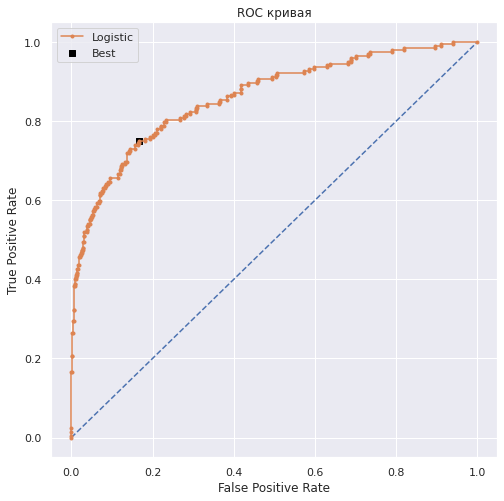

In [50]:
y_pred_proba = best_rf.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Best Threshold=',best_threshold)

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='s', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.show()

Порог принятия решения при котором достигается оптимальный баланс TPR и FPR найден, теперь сделаем предсказания на валидационной выборке и посмотрим метрики F1 и ROC-AUC:

In [51]:
y_pred_new_trhd = (y_pred_proba >= best_threshold) * 1

print('Random Forest valid Accuracy:', accuracy_score(y_valid, y_pred_new_trhd))
print('Random Forest valid F1-score', f1_score(y_valid, y_pred_new_trhd))
print('Random Forest valid ROC-AUC', roc_auc_score(y_valid, y_pred_proba))

Random Forest valid Accuracy: 0.817
Random Forest valid F1-score 0.6257668711656442
Random Forest valid ROC-AUC 0.8613163858508226


#### Определение порога по PR кривой (через F1-score)

Best Threshold=0.3469638215842148:.f, F1-Score=0.6531645569620254:.3f


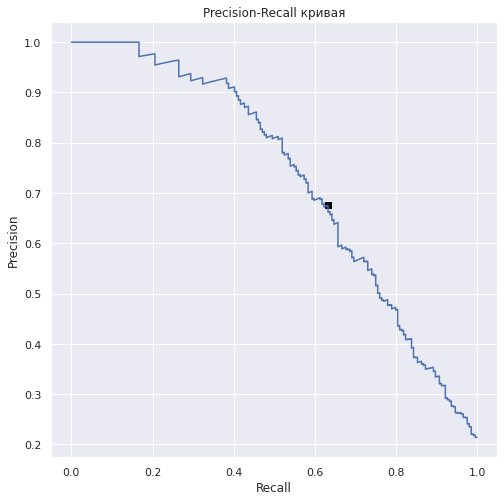

In [52]:
prec, rec, thresholds = precision_recall_curve(y_valid, y_pred_proba)

fscore = (2 * prec * rec) / (prec + rec)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}:.f, F1-Score={fscore[ix]}:.3f')
plt.plot(rec, prec)
plt.scatter(rec[ix], prec[ix], marker='s', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.show()

In [53]:
best_threshold = thresholds[ix]
y_pred_new_trhd = (y_pred_proba >= best_threshold) * 1
print('Random Forest Accuracy:', accuracy_score(y_valid, y_pred_new_trhd))
print('Random Forest F1-score', f1_score(y_valid, y_pred_new_trhd))
print('Random Forest ROC-AUC', roc_auc_score(y_valid, y_pred_proba))

Random Forest Accuracy: 0.863
Random Forest F1-score 0.6531645569620254
Random Forest ROC-AUC 0.8613163858508226


Значительно удалось увеличить метрики для случайного леса при помощи изменения порога принятия решения.

Однако стоит учесть что для этого пришлось использовать данные валидационной выборки и тем самым подстроиться под нее. Нельзя утверждать что на новых незнакомых данных модель покажет такие же высокие показатели или близкие к ним.

### Борьба с дисбалансом при помощи метода upsampling

Сбалансируем обучающую выборку методом upsampling чтобы классы были представлены более равнозначно:

In [54]:
def upsample(X, y, repeat):
    X_0 = X[y == 0]
    X_1 = X[y == 1]
    y_0 = y[y == 0]
    y_1 = y[y == 1]

    X_upsampled = pd.concat([X_0] + [X_1] * repeat)
    y_upsampled = pd.concat([y_0] + [y_1] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=42)
    
    return X_upsampled, y_upsampled



#### Логистическая регрессия

In [56]:
X_train_temp, X_valid_temp, y_train_temp, y_valid_temp = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [57]:
X_train_temp, y_train_temp = upsample(X_train_temp, y_train_temp, 4)

In [58]:
X_train_up = pd.concat([X_train_temp, X_valid_temp])
y_train_up = pd.concat([y_train_temp, y_valid_temp])

In [59]:
test_fold = [0 if x in X_valid_temp.index else -1 for x in X_train_up.index ]

In [60]:
ps = PredefinedSplit(test_fold)

In [61]:
grid_params = {'max_iter': range(100, 1000, 100),
              'solver': ['lbfgs', 'liblinear']}
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

lr = LogisticRegression(random_state=25, n_jobs=-1)
grid_search_cv_lr = GridSearchCV(lr, grid_params, cv=ps, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_lr.fit(X_train_up, y_train_up)

best_lr = grid_search_cv_lr.best_estimator_
ix = grid_search_cv_lr.best_index_

print('Logistic Regression best params:', grid_search_cv_lr.best_params_)
print()
print('Logistic Regression best f1:', grid_search_cv_lr.best_score_)
print('Logistic Regression best AUC:', grid_search_cv_lr.cv_results_['mean_test_AUC'][ix])

Logistic Regression best params: {'max_iter': 100, 'solver': 'liblinear'}

Logistic Regression best f1: 0.47754654983570644
Logistic Regression best AUC: 0.7610387482591956


#### Случайный лес

In [62]:
grid_params = {'min_samples_split': [2,4],
               'min_samples_leaf': [1,2],
              'n_estimators':[50,75,100,200,400],
              'max_depth':[4,6,8,12],
               }
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_cv_rf = GridSearchCV(rf, grid_params, cv=ps, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_rf.fit(X_train_up, y_train_up)

best_rf = grid_search_cv_rf.best_estimator_
ix = grid_search_cv_rf.best_index_

print('Random Forest best params:', grid_search_cv_rf.best_params_)
print()
print('Random Forest best f1:', grid_search_cv_rf.best_score_)
print('Random Forest best AUC:', grid_search_cv_rf.cv_results_['mean_test_AUC'][ix])



Random Forest best params: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest best f1: 0.6228070175438597
Random Forest best AUC: 0.8587323219911078


#### XGBoost

In [63]:
grid_params = {'max_depth': [2,4,8,12],
             'n_estimators': [75,85,95],
             'colsample_bylevel':[0.8,1],
             'colsample_bynode':[0.8,1],
             'colsample_bytree':[0.95,1],
             'learning_rate':[0.01, 0.1]
             }
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

clf = XGBClassifier(random_state=42, verbosity=0)
grid_search_xgb = GridSearchCV(estimator=clf, param_grid=grid_params, cv=ps, n_jobs=-1, scoring=scoring, refit='F1-score')

grid_search_xgb.fit(X_train_up, y_train_up)

best_xgb= grid_search_xgb.best_estimator_
ix = grid_search_xgb.best_index_

print('XGBoost best params:', grid_search_xgb.best_params_)
print()
print('XGBoost best f1:', grid_search_xgb.best_score_)
print('XGBoost best AUC:', grid_search_xgb.cv_results_['mean_test_AUC'][ix])

XGBoost best params: {'colsample_bylevel': 0.8, 'colsample_bynode': 1, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 85}

XGBoost best f1: 0.6051873198847264
XGBoost best AUC: 0.8568456747370486


Так как мы изменили баланс классов(а по сути изменили данные), то вполне ожидаемо, что метрики находятся на высочайшем уровне. Необходимо проверить как поведут себя модели на валидации:

In [64]:
print('Logistic Regression Validation Upsampled f1:', f1_score(y_valid, best_lr.predict(X_valid)))
print('Logistic Regression Validation Upsampled AUC:', roc_auc_score(y_valid, best_lr.predict_proba(X_valid)[:,1]))
print()
print('Random Forest Validation Upsampled f1:', f1_score(y_valid, best_rf.predict(X_valid)))
print('Random Forest Validation Upsampled AUC:', roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:,1]))
print()
print('XGBoost Validation Upsampled f1:', f1_score(y_valid, best_xgb.predict(X_valid)))
print('XGBoost Validation Upsampled AUC:', roc_auc_score(y_valid, best_xgb.predict_proba(X_valid)[:,1]))

Logistic Regression Validation Upsampled f1: 0.5223880597014925
Logistic Regression Validation Upsampled AUC: 0.7859025519755641

Random Forest Validation Upsampled f1: 0.625
Random Forest Validation Upsampled AUC: 0.8603433835845895

XGBoost Validation Upsampled f1: 0.6264501160092808
XGBoost Validation Upsampled AUC: 0.8543760469011724


На валидационной выборке модели показали себя значительно хуже чем на данных, которые были изменены и ребалансированнны. Разница в метриках на обучающих и валидационных данных свидетельствует о переобучении моделей.

### Борьба с дисбалансом при помощи изменения весов классов

#### Логистическая регрессия

In [65]:
grid_params = {'max_iter': range(100, 1000, 100),
              'solver': ['lbfgs', 'liblinear']}
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

lr = LogisticRegression(random_state=25, n_jobs=-1, class_weight='balanced')
grid_search_cv_lr = GridSearchCV(lr, grid_params, cv=kfold, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_lr.fit(X_train_up, y_train_up)

best_lr = grid_search_cv_lr.best_estimator_
ix = grid_search_cv_lr.best_index_

print('Logistic Regression best params:', grid_search_cv_lr.best_params_)
print()
print('Logistic Regression best f1:', grid_search_cv_lr.best_score_)
print('Logistic Regression best AUC:', grid_search_cv_lr.cv_results_['mean_test_AUC'][ix])

Logistic Regression best params: {'max_iter': 100, 'solver': 'lbfgs'}

Logistic Regression best f1: 0.681587492482421
Logistic Regression best AUC: 0.7679477796881645


#### Random Forest

In [66]:
grid_params = {'min_samples_split': [2],
              'n_estimators':[50,75,100,200,400],
              'max_depth':[10,12,16],
               'class_weight': [{0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}]}
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_cv_rf = GridSearchCV(rf, grid_params, cv=kfold, n_jobs=-1, scoring=scoring, refit='F1-score')
grid_search_cv_rf.fit(X_train, y_train)

best_rf = grid_search_cv_rf.best_estimator_
ix = grid_search_cv_rf.best_index_

print('Random Forest best params:', grid_search_cv_rf.best_params_)
print()
print('Random Forest best f1:', grid_search_cv_rf.best_score_)
print('Random Forest best AUC:', grid_search_cv_rf.cv_results_['mean_test_AUC'][ix])

Random Forest best params: {'class_weight': {0: 1, 1: 4}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 400}

Random Forest best f1: 0.6122280519933558
Random Forest best AUC: 0.8556067612383268


#### XGBoost

In [67]:
grid_params = {'max_depth': [2,4,8,12],
             'n_estimators': [75,85,95],
             'colsample_bylevel':[0.8,1],
             'colsample_bynode':[0.8,1],
             'colsample_bytree':[0.95,1],
             'learning_rate':[0.01, 0.1],
             'scale_pos_weight': [2,3]
             }
scoring = {"AUC": "roc_auc", "F1-score": 'f1'}

In [68]:
xgb_cl = XGBClassifier(verbosity=0, random_state=42)
grid_cv_xgb = GridSearchCV(xgb_cl, grid_params, n_jobs=-1, cv=kfold, scoring=scoring, refit='F1-score')
grid_cv_xgb.fit(X_train, y_train)
print('Best XGB params', grid_cv_xgb.best_params_)
print('Best XGB F1', grid_cv_xgb.best_score_)

Best XGB params {'colsample_bylevel': 0.8, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 75, 'scale_pos_weight': 2}
Best XGB F1 0.6247855498405959


In [69]:
best_xgb= grid_cv_xgb.best_estimator_
ix = grid_cv_xgb.best_index_

print('XGBoost best params:', grid_cv_xgb.best_params_)
print()
print('XGBoost best F1:', grid_cv_xgb.best_score_)
print('XGBoost best AUC:', grid_cv_xgb.cv_results_['mean_test_AUC'][ix])

XGBoost best params: {'colsample_bylevel': 0.8, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 75, 'scale_pos_weight': 2}

XGBoost best F1: 0.6247855498405959
XGBoost best AUC: 0.8624610712828235


## Тестирование модели

Протестируем модель показавшую лучшие результаты на валидации:

In [70]:
print('XGBoost Accuracy:', accuracy_score(y_test, best_xgb.predict(X_test)))
print('XGBoost F1:', f1_score(y_test, best_xgb.predict(X_test)))
print('XGBoost AUC:', roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

XGBoost Accuracy: 0.856
XGBoost F1: 0.634517766497462
XGBoost AUC: 0.8724263554772029


## Итоговый вывод:

1. Были проанализированны данные клиентов банка расторгнувших или не расторгнувших договор. Клиентов, расторгнувших договор, гораздо меньше чем тех кто остался.
2. Признаками для обучения предсказательной модели были такие параметры как пол, возраст, страна проживания, предположительный доход, количество продуктов и др.
3. Для борьбы с дисбалансом классов использовались методы: изменение порога принятия решения, upsampling и подбор весов классов. Все методы показали достаточную эффективность, но на upsampling  модели очевидно переобучились, а при изменении порога принятия решения мы подстраивались под валидационные данные, что не очень хорошо в контексте будущих новых данных.
4. Наилучшие результаты показала модель XGBoost с показателями f1 = 0.6345 и roc auc = 0.8724